In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### PART1: Modeling

##### 1. Download and Clean Data

In [2]:
tickers = {
    'stock': 'TSLA',
    'benchmark': '^IXIC'
}

date_start = '2021-01-01'
date_end = '2024-12-31'

def yfinance_download(ticker):
    try:
        df = yf.download(ticker, start=date_start, end=date_end, auto_adjust=True)
        df.columns = ['_'.join(col).strip() for col in df.columns]
        if df.empty:
            raise ValueError(f'No data retrieved for {ticker}')
        return df
    except Exception as e:
        print(f'Error downloading {ticker}: {str(e)}')
        return pd.DataFrame()

# Download and align data
data_stock = yfinance_download(tickers['stock'])
data_bench = yfinance_download(tickers['benchmark'])

if data_stock.empty or data_bench.empty:
    raise ValueError("Failed to download stock or benchmark data.")

merged_data = data_stock.merge(data_bench[f'Close_{tickers["benchmark"]}'], left_index=True, right_index=True, how='left')

# Add Federal Funds Rate
try:
    data_rate = pd.read_csv('Federal fund rate.csv', parse_dates=['Date'], index_col='Date')
    merged_data = merged_data.merge(data_rate, left_index=True, right_index=True, how='left')
    merged_data['EFFR'] = merged_data['EFFR'].ffill()
except Exception as e:
    print(f"Error loading Federal Funds Rate data: {e}")
    merged_data['EFFR'] = 0  # Default to 0 if data is unavailable

merged_data.dropna(inplace=True)
merged_data.rename(columns={f'Close_{tickers["stock"]}': 'Close', f'High_{tickers["stock"]}': 'High',
                    f'Low_{tickers["stock"]}': 'Low', f'Open_{tickers["stock"]}': 'Open',
                    f'Volume_{tickers["stock"]}': 'Volume', f'Close_{tickers["benchmark"]}': 'Close_Bench'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##### 2. Feature Engineering

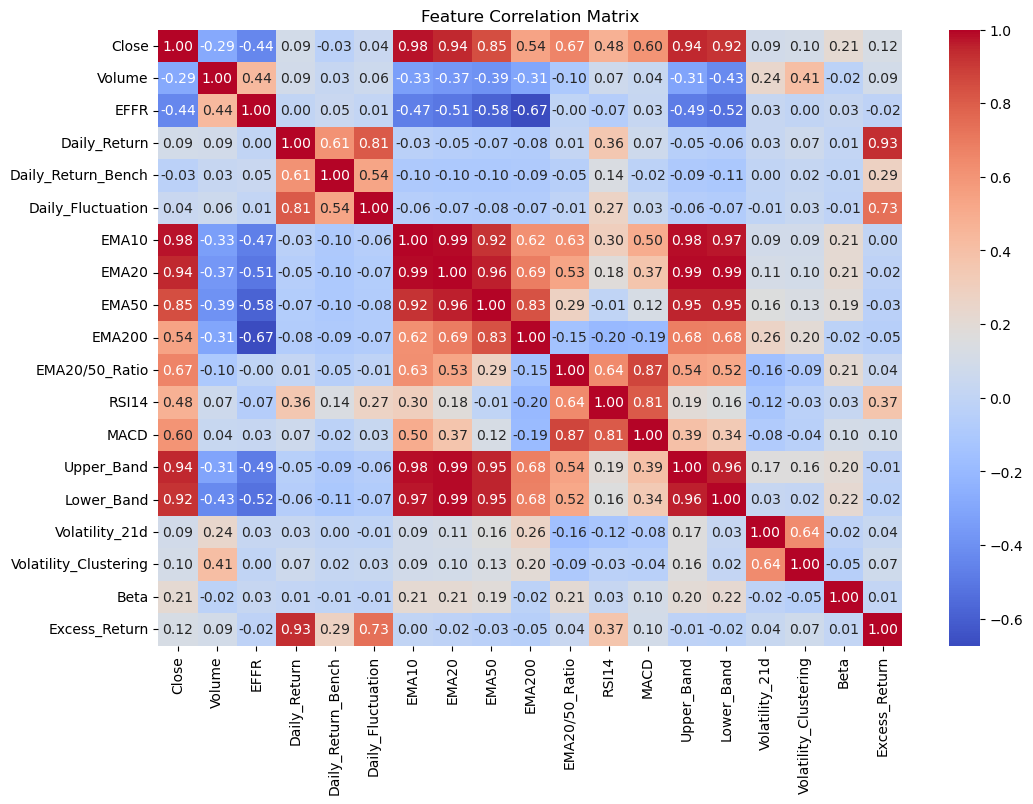

In [3]:
class FeatureEngineer:
    def __init__(self, lookback_window=90):
        self.lookback = lookback_window
        
    def add_features(self, df):
        df = self._add_essential_features(df)
        df = self._add_momentum_indicators(df)
        df = self._add_volatility_measures(df)
        df = self._add_benchmark_relationships(df)
        #df = self._add_cyclical_time_features(df)
        return df.dropna()
    
    def _add_essential_features(self, df):       
        df['Daily_Return'] = df['Close'].pct_change()
        df['Daily_Return_Bench'] = df['Close_Bench'].pct_change()
        df['Daily_Fluctuation'] = df['Close'] / df['Open'] - 1
        df['EMA10'] = df['Close'].ewm(span=10, adjust=True).mean()
        df['EMA20'] = df['Close'].ewm(span=20,adjust=True).mean()
        df['EMA50'] = df['Close'].ewm(span=50, adjust=True).mean()
        df['EMA200'] =  df['Close'].ewm(span=200, adjust=True).mean()
        df['EMA20/50_Ratio'] = df['EMA20'] / df['EMA50']
        return df
    
    def _add_momentum_indicators(self, df):
        df['RSI14'] = self._calculate_rsi(df['Close'])
        df['MACD'] = self._calculate_macd(df['Close'])
        df['Upper_Band'] = df['EMA20'] + df['Close'].rolling(window=20).std()
        df['Lower_Band'] = df['EMA20'] - df['Close'].rolling(window=20).std()
        return df
    
    def _add_volatility_measures(self, df):
        df['Volatility_21d'] = df['Daily_Return'].rolling(21).std() * np.sqrt(252)  # Annualized
        df['Volatility_Clustering'] = df['Daily_Return'].abs().rolling(5).mean()  # Short-term clustering
        return df

    def _add_benchmark_relationships(self, df):
        df['Beta'] = self._calculate_beta(df['Close'], df['Close_Bench'], df['EFFR'])
        df['Excess_Return'] = df['Daily_Return']-df['Daily_Return_Bench']
        return df
    
    def _calculate_rsi(self, series, window=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
        avg_loss = loss.ewm(com=window-1, min_periods=window).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))

    def _calculate_macd(self, series, fast=12, slow=26, signal=9):
        ema_fast = series.ewm(span=fast, adjust=False).mean()
        ema_slow = series.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        return macd

    def _calculate_beta(self, stock, bench, risk_free):
        excess_stock = stock.pct_change() - risk_free / 252
        excess_bench = bench.pct_change() - risk_free / 252
        covariance = excess_stock.rolling(self.lookback).cov(excess_bench)
        variance = excess_bench.rolling(self.lookback).var()
        return covariance / variance

# Apply feature engineering
engineer = FeatureEngineer()
merged_data = engineer.add_features(merged_data)
model_data = merged_data.drop(columns=['High', 'Low', 'Open', 'Close_Bench'])

# Check correlation among features
plt.figure(figsize=(12, 8))
sns.heatmap(model_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

##### 3. Data Preprocessing 
Split, Scale, Create Sliding Windows

In [4]:
# Split the data into training and testing sets
window_size = 10
train_size = int(len(model_data) * 0.8)
training = model_data[:train_size].copy()
backtest = model_data[-200:].copy()

if len(backtest) - window_size < 90:
    warnings.warn('Evaluating period less than 90 days.', category=UserWarning)

# Scaling the data
features = ['Close','Volume','EFFR','Daily_Fluctuation','EMA20/50_Ratio','RSI14','MACD','Volatility_21d',
           'Volatility_Clustering','Beta','Excess_Return']
scaler = MinMaxScaler()
scaled_training = scaler.fit_transform(training[features])

# Sliding window
look_ahead = 1
train_end = int(len(scaled_training) * 0.9)
X_train, y_train, X_test, y_test = [], [], [], []

# Sliding window for training
for i in range(0, train_end - window_size - look_ahead + 1):
    X_train.append(scaled_training[i:i + window_size])
    y_train.append(scaled_training[i + window_size + look_ahead - 1, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Sliding window for testing
for j in range(train_end, len(scaled_training) - window_size - look_ahead + 1):
    X_test.append(scaled_training[j:j + window_size])
    y_test.append(scaled_training[j + window_size + look_ahead - 1, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape data for NN
X_train_nn = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_nn = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Check shapes
print(f"X_train shape: {X_train.shape}")  # (train_samples, window_size, num_features)
print(f"X_train_nn shape: {X_train_nn.shape}")    # (test_samples, window_size, num_features)
print(f"y_train shape: {y_train.shape}")  # (train_samples,)
print(f"X_test shape: {X_test.shape}")    # (test_samples, window_size, num_features)
print(f"X_test_nn shape: {X_test_nn.shape}")    # (test_samples,)
print(f"y_test shape: {y_test.shape}")    # (test_samples,)


X_train shape: (647, 10, 11)
X_train_nn shape: (647, 110)
y_train shape: (647,)
X_test shape: (64, 10, 11)
X_test_nn shape: (64, 110)
y_test shape: (64,)


##### 4. Build Models

In [5]:
# =========================
# Model1: NN
# =========================
# Build NN model
nn_model = Sequential()
nn_model.add(Input(shape=(X_train_nn.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1))

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
rnn_history = nn_model.fit(X_train_nn, y_train, batch_size=64, epochs=20, verbose=0)

In [6]:
# =========================
# Model2: RNN
# =========================
def build_rnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(100, return_sequences=True),
        BatchNormalization(), 
        Dropout(0.3), 
        SimpleRNN(50, return_sequences=False),
        BatchNormalization(), 
        Dropout(0.3), 
        Dense(25, activation='relu'), 
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse') 
    return model

# Build RNN model
rnn_model = build_rnn((X_train.shape[1], X_train.shape[2])) 

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=50, 
    callbacks=[early_stopping],
    verbose=0
)

In [7]:
# =========================
# Model3: LSTM
# =========================
def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        BatchNormalization(), 
        Dropout(0.2), 
        LSTM(50, return_sequences=False),
        BatchNormalization(), 
        Dropout(0.3),
        Dense(25, activation='relu'), 
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse')  
    return model

# Build LSTM model
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2])) 

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50, 
    callbacks=[early_stopping],
    verbose=0
)

##### 5. Evaluate Models

In [8]:
# ==============
# Scaled
# ==============
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Predict and evaluate NN
nn_pred = nn_model.predict(X_test_nn)
nn_metrics = evaluate_model(y_test, nn_pred)

# Predict and evaluate RNN
rnn_pred = rnn_model.predict(X_test)
rnn_metrics = evaluate_model(y_test, rnn_pred)

# Predict and evaluate LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_metrics = evaluate_model(y_test, lstm_pred)

# Create a comparison table
metrics_comparison = pd.DataFrame({
    'NN': nn_metrics, 
    'RNN': rnn_metrics,
    'LSTM': lstm_metrics
})

print("Model Performance Comparison:")
print(metrics_comparison)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Model Performance Comparison:
            NN       RNN      LSTM
MAE   0.034365  0.094540  0.042243
MSE   0.001748  0.010116  0.002296
RMSE  0.041804  0.100578  0.047915


In [9]:
# ================
# Unscaled
# ================
def unscale_predictions(scaler, y_true, y_pred, feature_index):
    # Create a dummy array to inverse transform
    dummy_array = np.zeros((len(y_true), scaler.n_features_in_))
    dummy_array[:, feature_index] = y_true
    y_true_unscaled = scaler.inverse_transform(dummy_array)[:, feature_index]
    
    dummy_array[:, feature_index] = y_pred
    y_pred_unscaled = scaler.inverse_transform(dummy_array)[:, feature_index]
    
    return y_true_unscaled, y_pred_unscaled

# Unscale the predictions
feature_index = model_data.columns.get_loc('Close')
y_test_unscaled, nn_pred_unscaled = unscale_predictions(scaler, y_test, nn_pred.flatten(), feature_index)
_, rnn_pred_unscaled = unscale_predictions(scaler, y_test, rnn_pred.flatten(), feature_index)
_, lstm_pred_unscaled = unscale_predictions(scaler, y_test, lstm_pred.flatten(), feature_index)

# Evaluate backtesting performance
nn_unscaled_metrics = evaluate_model(y_test_unscaled, nn_pred_unscaled)
rnn_unscaled_metrics = evaluate_model(y_test_unscaled, rnn_pred_unscaled)
lstm_unscaled_metrics = evaluate_model(y_test_unscaled, lstm_pred_unscaled)

# Create a comparison table for backtesting metrics
unscaled_metrics_comparison = pd.DataFrame({
    'NN': nn_unscaled_metrics,
    'RNN': rnn_unscaled_metrics,
    'LSTM': lstm_unscaled_metrics
})

print("Unscaled Model Performance Comparison:")
print(unscaled_metrics_comparison)

# Return the best model
def get_best_model(metrics_comparison, models_dict, metric='RMSE'):
    # Find the model with the lowest value for the specified metric
    best_model_name = metrics_comparison.loc[metric].idxmin()
    best_value = metrics_comparison.loc[metric].min()
    
    # Retrieve the best model object from the models_dict
    best_model = models_dict[best_model_name]
    
    print(f"\nBest model based on {metric}: {best_model_name} ({metric} = {best_value:.4f})")
    return best_model_name, best_model

# Dictionary mapping model names to their corresponding model objects
models_dict = {
    'NN': nn_model,  # Replace nn_model with your actual neural network model object
    'RNN': rnn_model,  # Replace rnn_model with your actual RNN model object
    'LSTM': lstm_model  # Replace lstm_model with your actual LSTM model object
}

# Compare models and return the best model object
best_model, model = get_best_model(unscaled_metrics_comparison, models_dict, metric='RMSE')

Unscaled Model Performance Comparison:
              NN         RNN        LSTM
MAE    10.373820   28.538647   12.751884
MSE   159.246075  921.822585  209.208283
RMSE   12.619274   30.361531   14.464034

Best model based on RMSE: NN (RMSE = 12.6193)


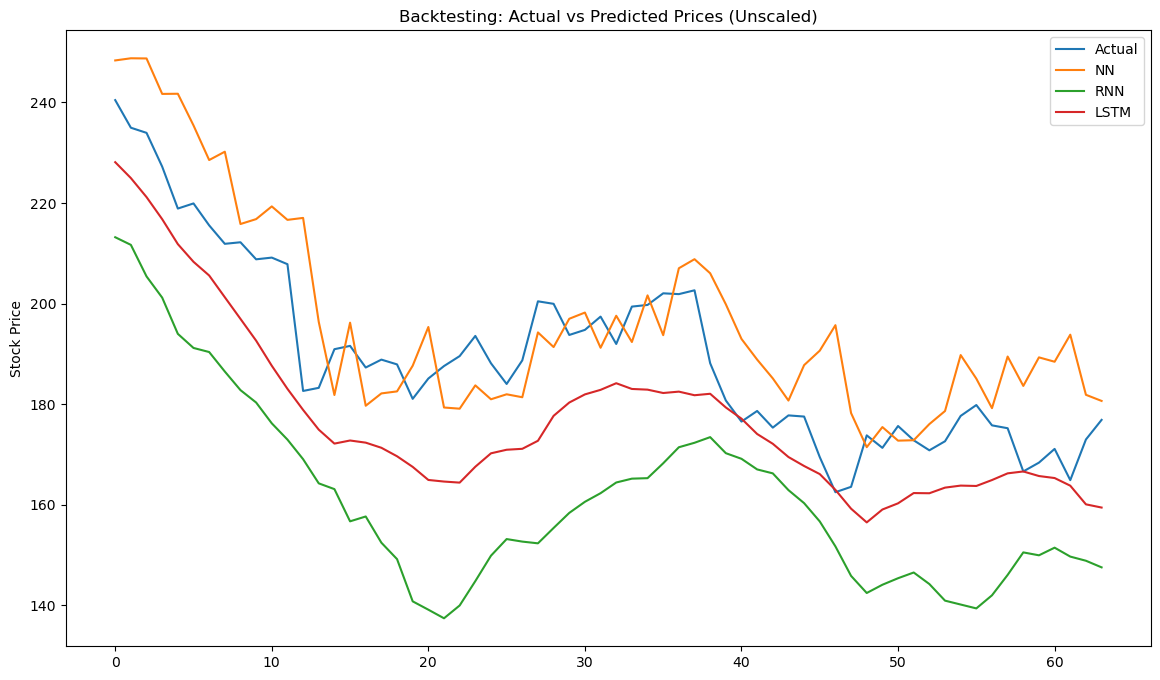

In [10]:
# Plot evaluation results
plt.figure(figsize=(14, 8))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(nn_pred_unscaled, label='NN')
plt.plot(rnn_pred_unscaled, label='RNN')
plt.plot(lstm_pred_unscaled, label='LSTM')
plt.title("Backtesting: Actual vs Predicted Prices (Unscaled)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### PART2: Backtesting

In [11]:
# Signal generation functions
def apply_price_cross_MA_strategy(data, day):
    data['Signal_mapc'+str(day)] = 0
    ema_column = 'EMA' + str(day)
    for i in range(1, len(data)):
        if data['Predicted_Close'].iloc[i] > data['Close'].iloc[i-1] and data['Predicted_Close'].iloc[i] > data[ema_column].iloc[i-1]:
            data.at[data.index[i], 'Signal_mapc'+str(day)] = 1  # Buy
        elif data['Predicted_Close'].iloc[i] < data['Close'].iloc[i-1] and data['Predicted_Close'].iloc[i] < data[ema_column].iloc[i-1]:
            data.at[data.index[i], 'Signal_mapc'+str(day)] = -1  # Sell
    return data

def apply_long_short_MA_strategy(data,short_term,long_term):
    data['Signal_mac'+str(short_term)+'vs'+str(long_term)] = 0
    ema_short = 'EMA' + str(short_term)
    ema_long = 'EMA' + str(long_term)
    for i in range(1, len(data)):
        if data['Predicted_Close'].iloc[i] > data['Close'].iloc[i-1] and data[ema_short].iloc[i-1] >= data[ema_long].iloc[i-1]:
            data.at[data.index[i], 'Signal_mac'+str(short_term)+'vs'+str(long_term)] = 1  # Buy
        elif data['Predicted_Close'].iloc[i] < data['Close'].iloc[i-1] and  data[ema_short].iloc[i-1] <= data[ema_long].iloc[i-1]:
            data.at[data.index[i], 'Signal_mac'+str(short_term)+'vs'+str(long_term)] = -1  # Sell
    return data

    
def apply_volatility_breakout_strategy(data):
    data['Signal_vb'] = 0
    for i in range(1, len(data)):
        if data['Predicted_Close'].iloc[i] > data['Close'].iloc[i-1] and data['Predicted_Close'].iloc[i] >= data['Upper_Band'].iloc[i-1]:
            data.at[data.index[i], 'Signal_vb'] = 1  # Buy
        elif data['Predicted_Close'].iloc[i] < data['Close'].iloc[i-1] and data['Predicted_Close'].iloc[i] <= data['Lower_Band'].iloc[i-1]:
            data.at[data.index[i], 'Signal_vb'] = -1  # Sell
    return data

def apply_momentum_strategy(data, threshold, shift_period):
    data['Signal_momentum'] = 0
    for i in range(shift_period, len(data)):
        if data['Predicted_Close'].iloc[i] > data['Close'].iloc[i - shift_period] * (1 + threshold):
            data.at[data.index[i], 'Signal_momentum'] = 1  # Buy
        elif data['Predicted_Close'].iloc[i] < data['Close'].iloc[i - shift_period] * (1 - threshold):
            data.at[data.index[i], 'Signal_momentum'] = -1  # Sell
    return data

In [12]:
# Trading strategy function
def trading(data, signal_col, method, initial_balance, position_size, transaction_fee):
    cash = initial_balance
    positions = 0
    total_trades = 0
    account_value = [cash]

    for i in range(1,len(data)):
        if method == 'all':
            if data[signal_col].iloc[i] == 1 and cash >= data['Open'].iloc[i] * (1 + transaction_fee):  # Buy signal
                new_positions = cash // (data['Open'].iloc[i] * (1 + transaction_fee))
                positions += new_positions
                cash -= new_positions * data['Open'].iloc[i] * (1 + transaction_fee)
                total_trades += 1
            elif data[signal_col].iloc[i] == -1 and positions > 0:  # Sell signal
                cash += positions * data['Open'].iloc[i] * (1 - transaction_fee)
                positions = 0
                total_trades += 1
        elif method == 'partial':
            if data[signal_col].iloc[i] == 1 and cash >= data['Open'].iloc[i] * position_size * (1 + transaction_fee):  # Buy signal
                positions += position_size
                cash -= data['Open'].iloc[i] * position_size * (1 + transaction_fee)
                total_trades += 1
            elif data[signal_col].iloc[i] == -1 and positions >= position_size:  # Sell signal
                positions -= position_size
                cash += data['Open'].iloc[i] * position_size * (1 - transaction_fee)
                total_trades += 1

        current_value = cash + positions * data['Close'].iloc[i]
        account_value.append(current_value)

    final_balance = cash + positions * data['Close'].iloc[-1]
    return final_balance, total_trades, account_value


In [13]:
# Function to plot trading strategies
def plot_trading_strategy(data, strategy, strategy_name,threshold, initial_balance, position_size, transaction_fee, short_term, long_term, mr_day):
    # Identify buy and sell signals
    buy_signals = data[data[strategy] == 1].index
    sell_signals = data[data[strategy] == -1].index

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot actual and predicted prices
    ax1.plot(data.index, data['Close'], label='Actual Prices', color='blue')
    ax1.plot(data.index, data['Predicted_Close'], label='Predicted Prices', color='orange')

    # Plot moving average or volatility bands based on strategy
    if 'Signal_mapc' in strategy:
        ema_col = strategy[-2:]
        ax1.plot(data.index, data['EMA' + ema_col], label=f'EMA{ema_col}', color='green')
    elif strategy == 'Signal_vb':
        ax1.plot(data.index, data['Upper_Band'], label='Upper_Band', color='green')
        ax1.plot(data.index, data['Lower_Band'], label='Lower_Band', color='red')
    elif strategy == 'Signal_mac'+str(short_term)+'vs'+str(long_term):
        ema_col_short = strategy[-6:-4]
        ema_col_long = strategy[-2:]
        ax1.plot(data.index, data['EMA'+ema_col_short], label=f'EMA{ema_col_short}', color='green')
        ax1.plot(data.index, data['EMA'+ema_col_long], label=f'EMA{ema_col_long}', color='red')
    elif strategy == 'Signal_mr'+str(mr_day):
        ema_col = strategy[-2:]
        ax1.plot(data.index, data['EMA'+ema_col]*(1+threshold), label='Overvalued_Band', color='green')
        ax1.plot(data.index, data['EMA'+ema_col]*(1-threshold), label='Undervalued_Band', color='red')
        

    # Plot buy and sell signals
    ax1.scatter(buy_signals, data.loc[buy_signals]['Close'], marker='^', color='green', label='Buy Points')
    ax1.scatter(sell_signals, data.loc[sell_signals]['Close'], marker='v', color='red', label='Sell Points')

    # Set labels and title for price plot
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_title(f'{strategy_name} - Prices and Signals')
    ax1.legend(loc='upper left')

    # Calculate account value change over time
    final_balance_all, total_trades_all, account_value_all = trading(data, strategy, 'all', initial_balance, position_size, transaction_fee)
    final_balance_par, total_trades_par, account_value_par = trading(data, strategy, 'partial', initial_balance, position_size, transaction_fee)

    # Create a secondary y-axis for account value
    fig, ax2 = plt.subplots(figsize=(12, 8))
    ax2.plot(data.index, data['Close'], label='Actual Prices', color='blue')
    # Plot buy and sell signals
    ax2.scatter(buy_signals, data.loc[buy_signals]['Close'], marker='^', color='green', label='Buy Points')
    ax2.scatter(sell_signals, data.loc[sell_signals]['Close'], marker='v', color='red', label='Sell Points')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.set_title(f'{strategy_name} - Account Value over Time')
    ax2.legend(loc='upper left')
    
    ax3 = ax2.twinx()
    ax3.plot(data.index, account_value_all, label='Account Value (all)', linestyle='--', color='green')
    ax3.plot(data.index, account_value_par, label='Account Value (partial)', linestyle='--', color='red')
    ax3.set_ylabel('Account Value')
    ax3.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [14]:
# Function to calculate performance metrics
def calculate_performance_metrics(account_value, risk_free_rate):
    total_return = account_value[-1] / initial_balance - 1
    annualized_return = ((account_value[-1] / initial_balance) ** (252 / len(account_value))) - 1
    
    returns = np.diff(account_value) / account_value[:-1]
    excess_returns = returns - (risk_free_rate / 252)  # daily
    avg_excess_return = np.mean(excess_returns) * 252  # annualized
    volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = avg_excess_return / volatility
    
    cumulative_returns = (1 + returns).cumprod()
    cumulative_returns = pd.Series(cumulative_returns)
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    return {
        'ending_balance':account_value[-1],
        'total_return': total_return,
        'annualized_return': annualized_return,
        'max_drawdown': max_drawdown,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio
    }


##### Apply Trading Strategies

In [15]:
# ==================
# Restructure data
# ==================

# Scaling backtesting data
scaled_backtesting = scaler.fit_transform(backtest.copy()[features])

# Sliding window for backtesting
X_test = []
for i in range(0,len(scaled_backtesting)-window_size-look_ahead+1):
    X_test.append(scaled_backtesting[i:i+window_size])
X_test = np.array(X_test)

# Apply model
if best_model == 'RNN':
    # Reshape data for modeling
    X_test_model = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    # Predict stock price using the best model
    scaled_y_pred_model = model.predict(X_test_model)
    scaled_y_pred_model = scaled_y_pred_model.reshape(-1, 1)
    y_pred_model = scaler.inverse_transform(np.hstack([scaled_y_pred_model] * len(features)))[:, 0]
else:
    X_test_model = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
    # Predict stock price using the best model
    scaled_y_pred_model = model.predict(X_test_model)
    scaled_y_pred_model = scaled_y_pred_model.reshape(-1, 1)
    y_pred_model = scaler.inverse_transform(np.hstack([scaled_y_pred_model] * len(features)))[:, 0]
    
# Prepare backtesting dataset
backtesting = backtest.copy()
backtesting.insert(1,'Predicted_Close',0)
backtesting.iloc[-len(y_pred_model):, 1] = y_pred_model
backtesting.drop(backtesting[backtesting['Predicted_Close'] == 0].index, inplace=True)
backtesting = backtesting.merge(merged_data['Open'],left_index=True, right_index=True, how='left')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [16]:
# ==========================
# Apply strategy functions
# ==========================
initial_balance = 10000
position_size = 5
transaction_fee = 0.005
threshold = 0.05 # divergent from mean price
risk_free_rate = backtesting['EFFR'].mean()/100

ma_day1 = 10
ma_day2 = 20
short_term = 20
long_term = 50
momentum_day = 10
mr_day = 10

backtesting = apply_price_cross_MA_strategy(backtesting, ma_day1)
backtesting = apply_price_cross_MA_strategy(backtesting, ma_day2)
backtesting = apply_long_short_MA_strategy(backtesting,short_term,long_term)
backtesting = apply_volatility_breakout_strategy(backtesting)
backtesting = apply_momentum_strategy(backtesting, threshold,momentum_day)

##### Evaluate strategies

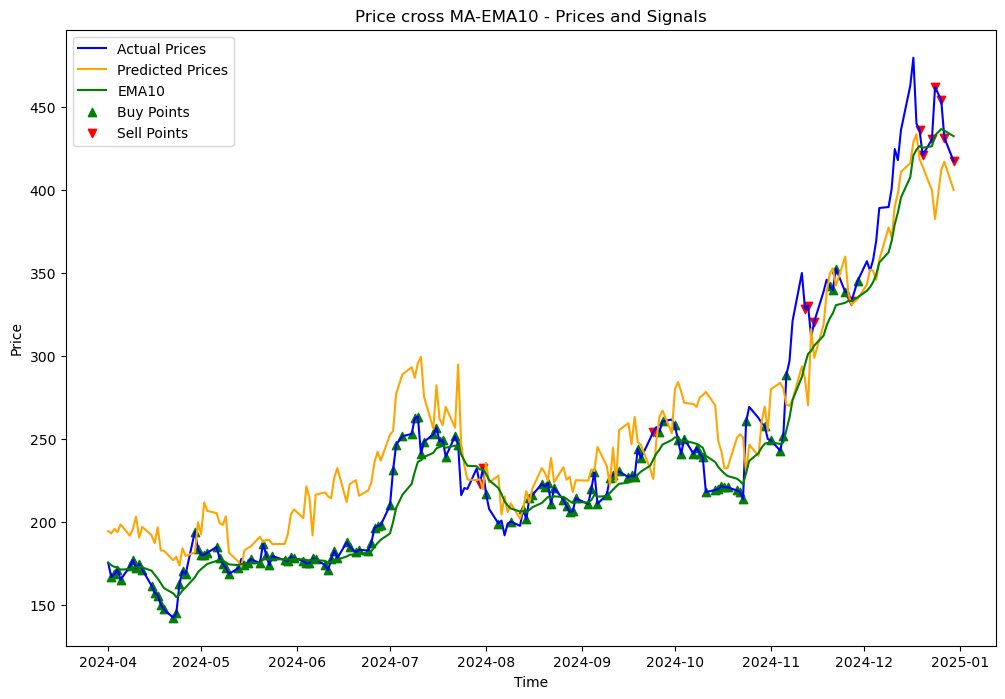

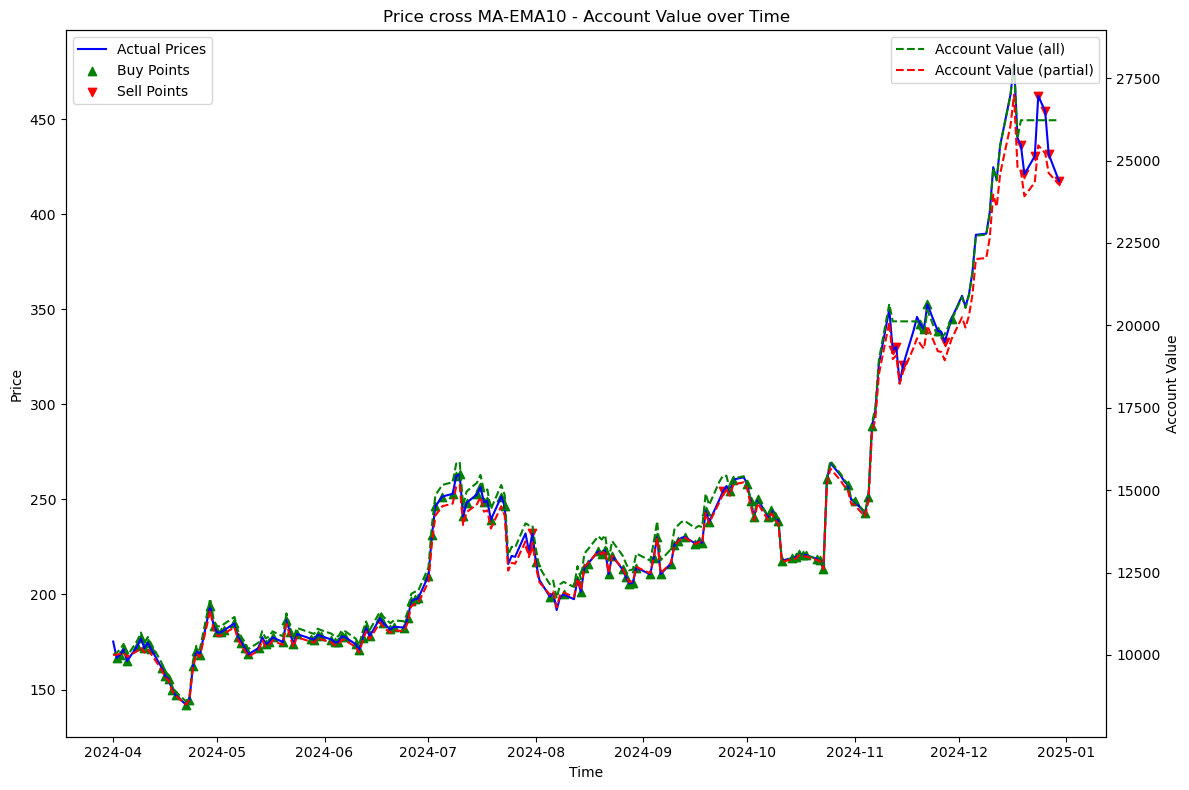

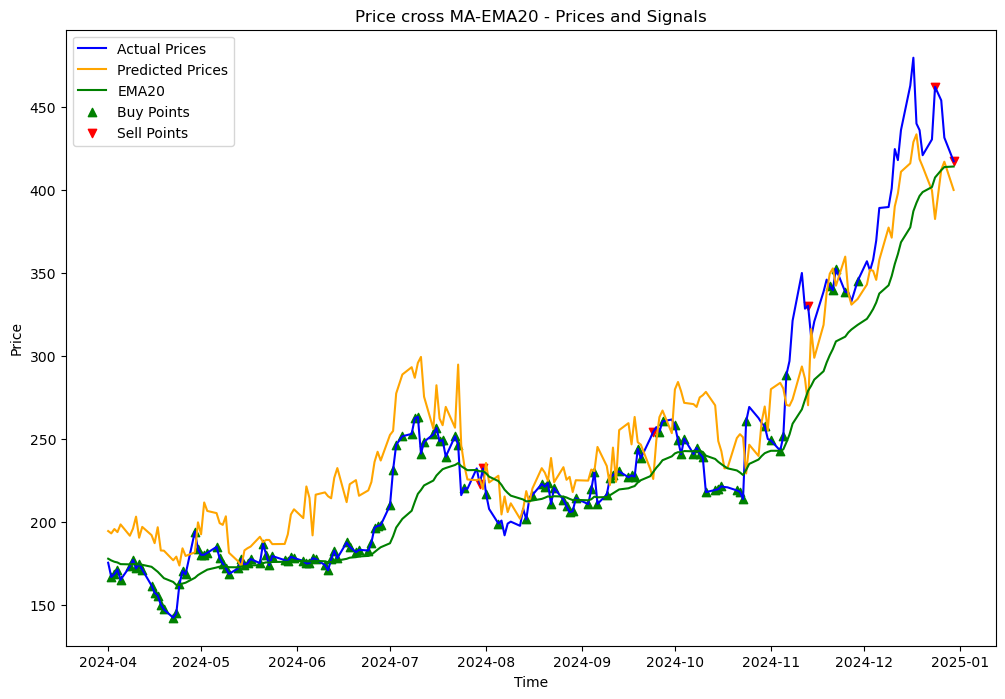

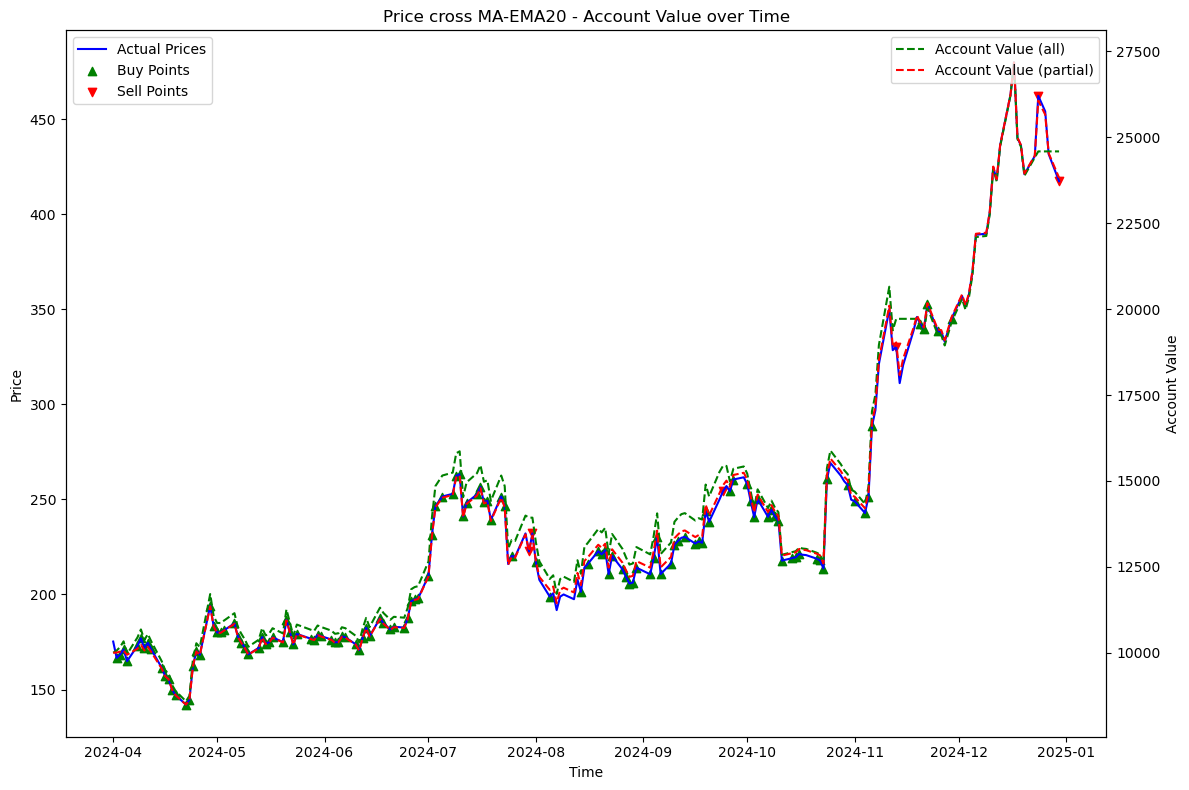

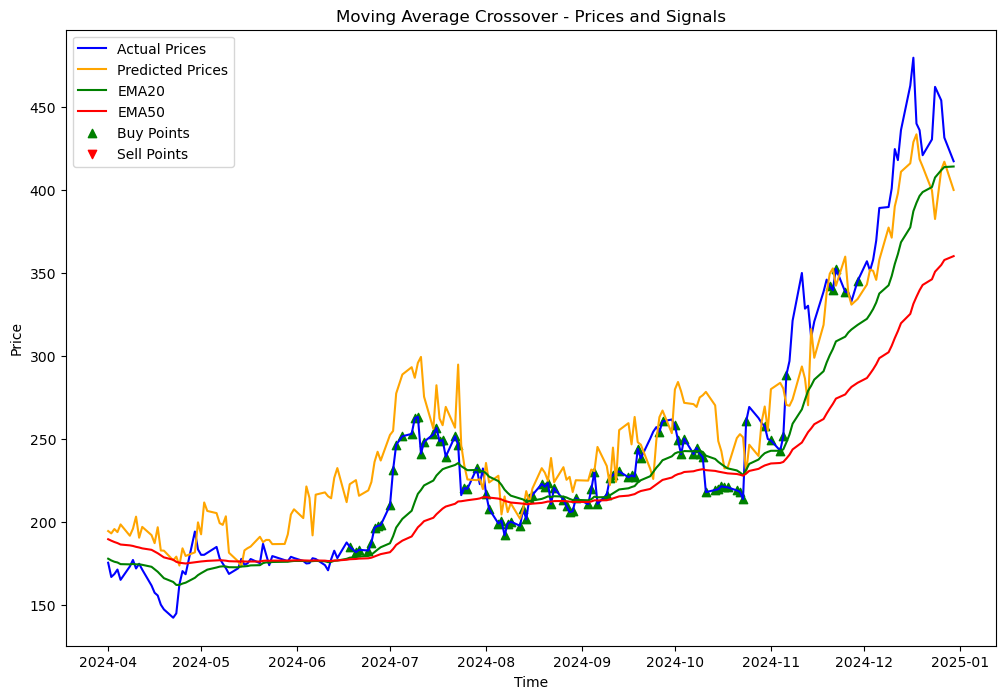

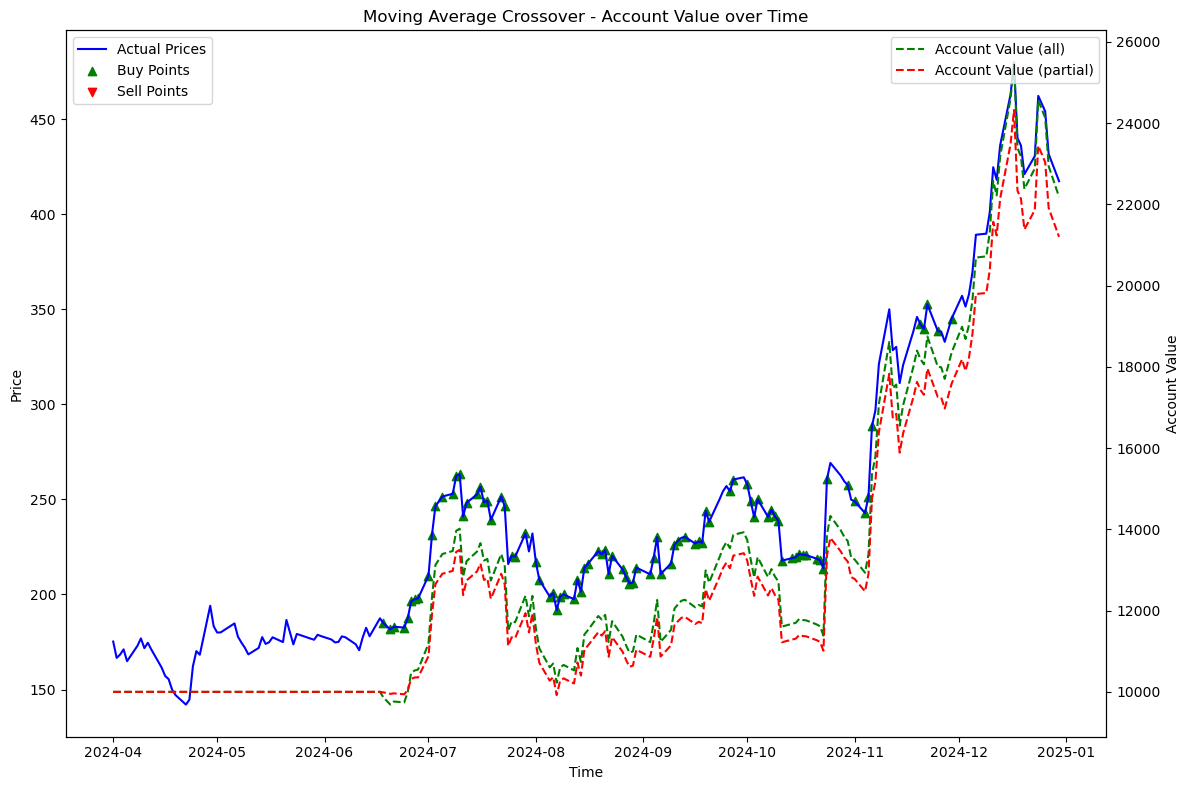

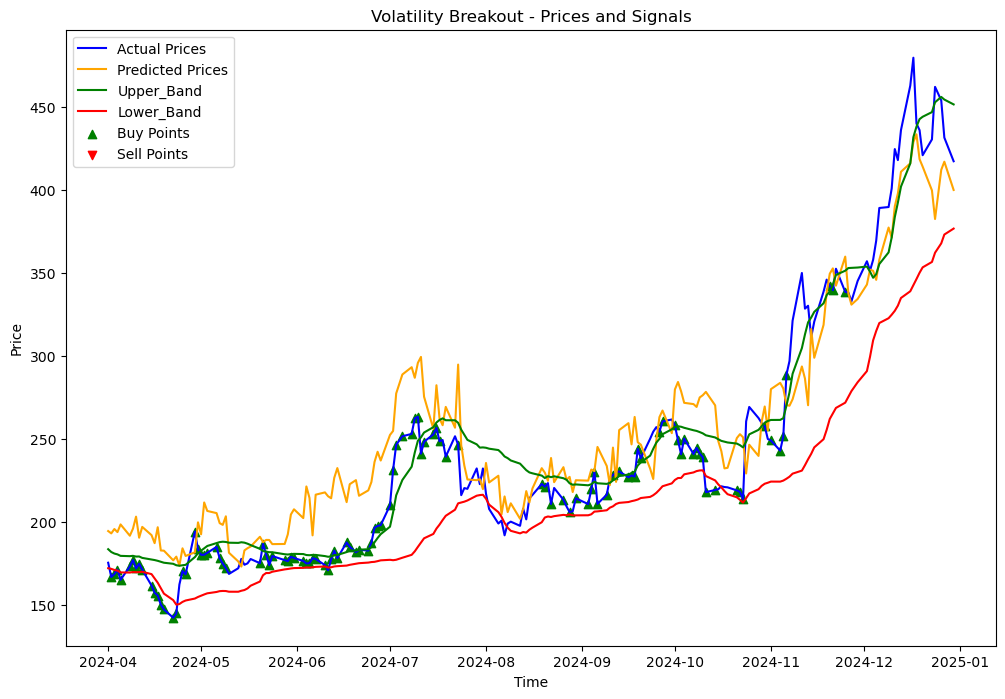

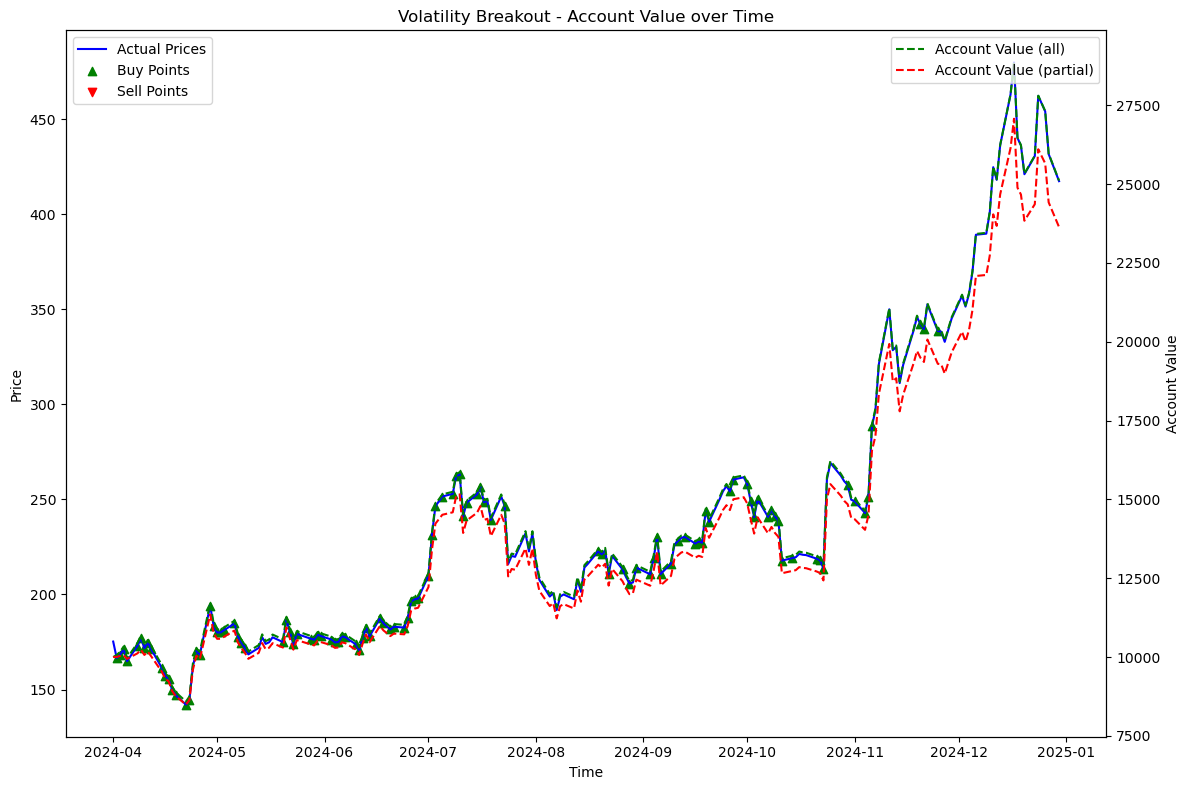

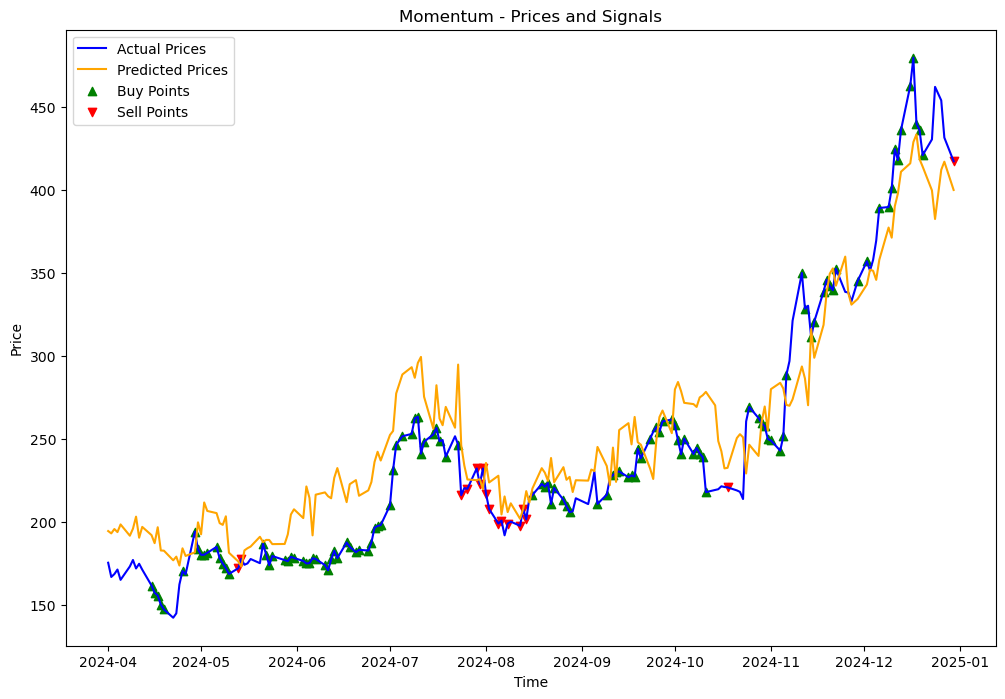

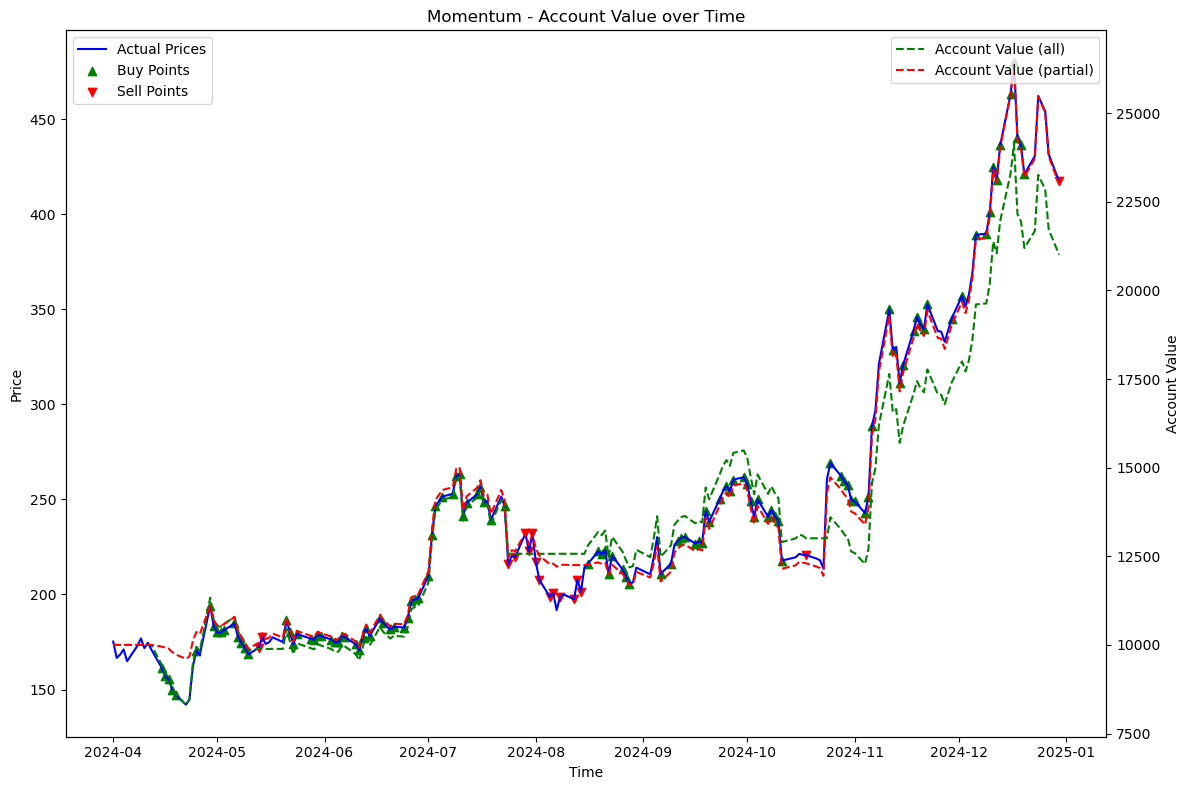

In [17]:
# ==========================
# Performance by strategies
# ==========================
strategies = {
    'Signal_mapc'+str(ma_day1): 'Price cross MA-EMA'+str(ma_day1),
    'Signal_mapc'+str(ma_day2): 'Price cross MA-EMA'+str(ma_day2),
    'Signal_mac'+str(short_term)+'vs'+str(long_term): 'Moving Average Crossover',
    'Signal_vb': 'Volatility Breakout',
    'Signal_momentum': 'Momentum'
}

for strategy, strategy_name in strategies.items():
    plot_trading_strategy(backtesting, strategy, strategy_name, threshold, initial_balance, position_size, transaction_fee, short_term, long_term, mr_day)

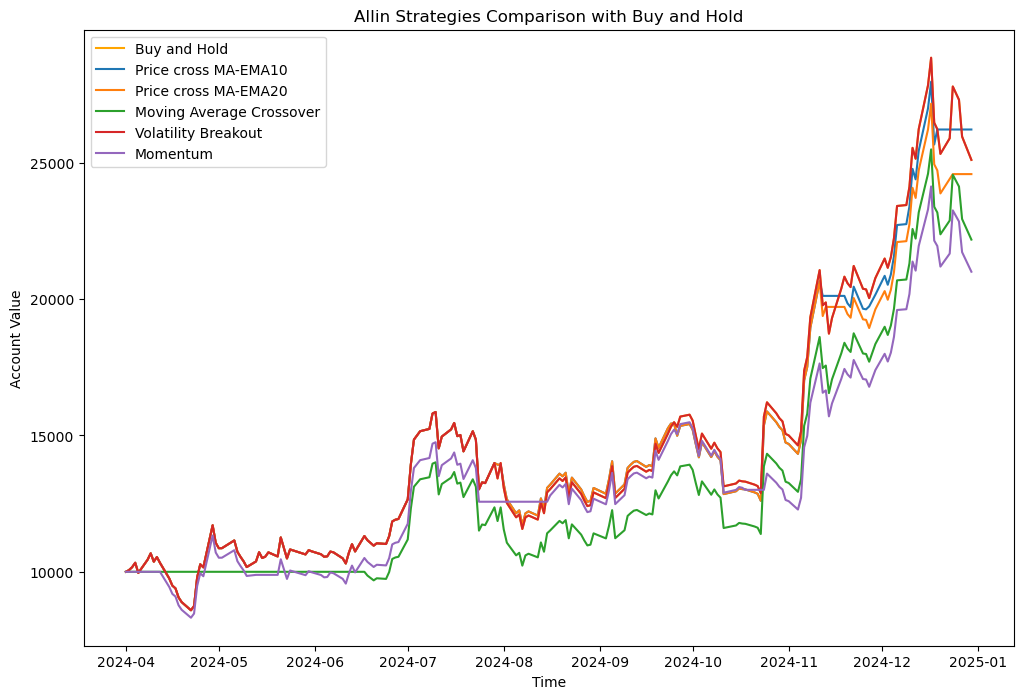

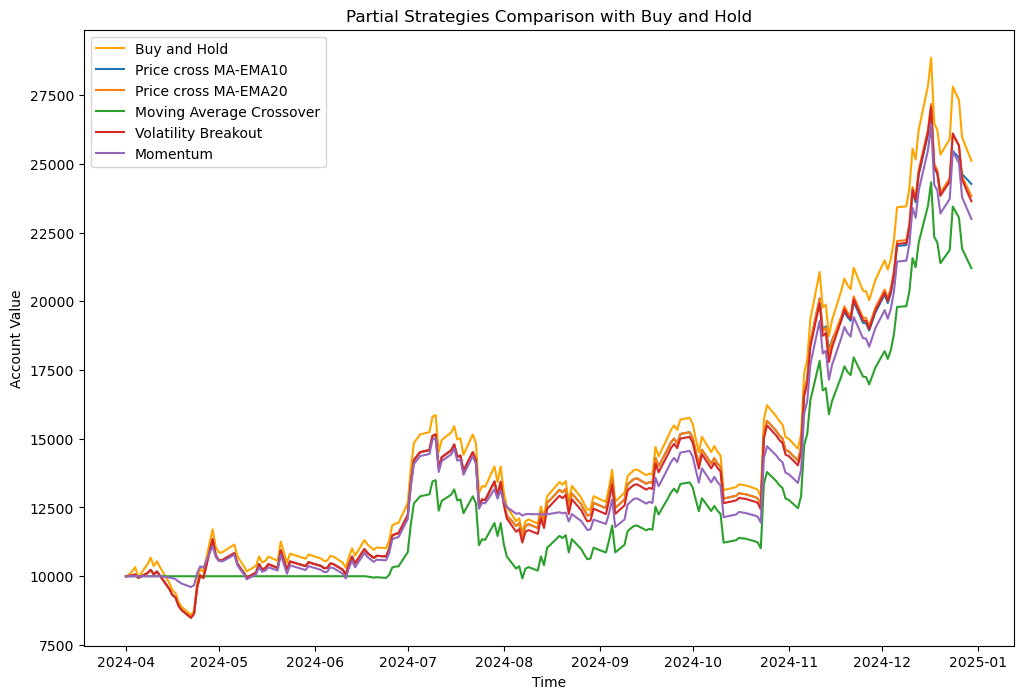

In [18]:
# ====================================================
# Compare strategies with buying and holding the stock
# ====================================================

# Calculate buy and hold strategy
benchmark_initial_balance = 10000
benchmark_shares = benchmark_initial_balance // (backtesting['Open'][1] * (1 + transaction_fee))
cash = benchmark_initial_balance - benchmark_shares * (backtesting['Open'][1] * (1 + transaction_fee))
benchmark_account_value = [benchmark_initial_balance, cash + benchmark_shares * backtesting['Close'][1]]

for price in backtesting['Close'][2:]:
    current_value = cash + benchmark_shares * price
    benchmark_account_value.append(current_value)

# Plot buy and hold benchmark strategy vs others
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot Buy and Hold vs. All in strategies
ax1.plot(backtesting.index, benchmark_account_value, label='Buy and Hold', color='orange')
for strategy, strategy_name in strategies.items():
    final_balance_all, total_trades_all, account_value_all = trading(backtesting, strategy, 'all', initial_balance, position_size, transaction_fee)
    ax1.plot(backtesting.index, account_value_all, label=strategy_name)
plt.title('Allin Strategies Comparison with Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Account Value')
plt.legend()
plt.show()

# Plot Buy and Hold vs. Partial strategies
fig, ax2 = plt.subplots(figsize=(12, 8))
ax2.plot(backtesting.index, benchmark_account_value, label='Buy and Hold', color='orange')
for strategy, strategy_name in strategies.items():
    final_balance_par, total_trades_par, account_value_par = trading(backtesting, strategy, 'partial', initial_balance, position_size, transaction_fee)
    ax2.plot(backtesting.index, account_value_par, label=strategy_name)
plt.title('Partial Strategies Comparison with Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Account Value')
plt.legend()
plt.show()



In [19]:
# ==========================
# Summarize performance
# ==========================

results = []

# Iterate over each strategy and calculate the performance metrics
for strategy, strategy_name in strategies.items():
    final_balance_all, total_trades_all, account_value_all = trading(backtesting, strategy, 'all', initial_balance, position_size, transaction_fee)
    final_balance_par, total_trades_par, account_value_par = trading(backtesting, strategy, 'partial', initial_balance, position_size, transaction_fee)
    metrics_all = calculate_performance_metrics(account_value_all, risk_free_rate)
    metrics_par = calculate_performance_metrics(account_value_par, risk_free_rate)
    
    # Append the results for 'all in' method
    results.append({
        'Strategy': strategy_name,
        'Method': 'All in',
        'Ending Balance': round(account_value_all[-1], 4),
        'Total Return': round(metrics_all['total_return'], 4),
        'Annualized Return': round(metrics_all['annualized_return'], 4),
        'Max Drawdown': round(metrics_all['max_drawdown'], 4),
        'Volatility': round(metrics_all['volatility'], 4),
        'Sharpe Ratio': round(metrics_all['sharpe_ratio'], 4)
    })
    
    # Append the results for 'partial' method
    results.append({
        'Strategy': strategy_name,
        'Method': 'Partial',
        'Ending Balance': round(account_value_par[-1], 4),
        'Total Return': round(metrics_par['total_return'], 4),
        'Annualized Return': round(metrics_par['annualized_return'], 4),
        'Max Drawdown': round(metrics_par['max_drawdown'], 4),
        'Volatility': round(metrics_par['volatility'], 4),
        'Sharpe Ratio': round(metrics_par['sharpe_ratio'], 4)
    })

# Calculate the performance metrics for the benchmark buy and hold strategy
benchmark_metrics = calculate_performance_metrics(benchmark_account_value,risk_free_rate)
results.append({
    'Strategy': 'Buy and Hold benchmark',
    'Method': 'N/A',
    'Ending Balance': round(benchmark_metrics['ending_balance'], 4),
    'Total Return': round(benchmark_metrics['total_return'], 4),
    'Annualized Return': round(benchmark_metrics['annualized_return'], 4),
    'Max Drawdown': round(benchmark_metrics['max_drawdown'], 4),
    'Volatility': round(benchmark_metrics['volatility'], 4),
    'Sharpe Ratio': round(benchmark_metrics['sharpe_ratio'], 4)
})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df.to_string(index=False))

                Strategy  Method  Ending Balance  Total Return  Annualized Return  Max Drawdown  Volatility  Sharpe Ratio
    Price cross MA-EMA10  All in      26224.0268        1.6224             2.5919       -0.2616      0.6438        2.2349
    Price cross MA-EMA10 Partial      24267.6967        1.4268             2.2409       -0.2453      0.6173        2.1374
    Price cross MA-EMA20  All in      24588.1780        1.4588             2.2978       -0.2616      0.6501        2.0869
    Price cross MA-EMA20 Partial      23822.9257        1.3823             2.1624       -0.2453      0.6246        2.0799
Moving Average Crossover  All in      22185.6119        1.2186             1.8774       -0.2704      0.5913        2.0029
Moving Average Crossover Partial      21201.9983        1.1202             1.7094       -0.2649      0.5741        1.9405
     Volatility Breakout  All in      25110.1752        1.5110             2.3910       -0.2705      0.6707        2.0851
     Volatility Breakout